<a href="https://colab.research.google.com/github/Rweissman7/Diagnosing-Hypothyroidism/blob/main/Copy3_Healthcare_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#connecting google colab to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#import pandas and scikit-learn
import pandas as pd
import numpy as np
import sklearn


In [ ]:
#google colab finding necessary files
!cp drive/MyDrive/labevents.csv.gz ./
!cp drive/MyDrive/omr.csv.gz ./
!cp drive/MyDrive/diagnoses_icd.csv.gz ./
!cp drive/MyDrive/d_labitems.csv.gz ./

In [ ]:
#load necessary tables
omr= pd.read_csv('omr.csv.gz',compression='gzip')
diagnoses = pd.read_csv('diagnoses_icd.csv.gz',compression='gzip')
lab_items = pd.read_csv('d_labitems.csv.gz',compression='gzip')

In [ ]:
#checking diagnoses table
print(diagnoses.head())

   subject_id   hadm_id  seq_num icd_code  icd_version
0    10000032  22595853        1     5723            9
1    10000032  22595853        2    78959            9
2    10000032  22595853        3     5715            9
3    10000032  22595853        4    07070            9
4    10000032  22595853        5      496            9


misdiagnosed - https://www.medicalnewstoday.com/articles/266780#diagnosis

**hypothyroidism - 244.8, 244.9 **

*   anxiety - 300.00, 300.01, 300.02, 300.09
*   bipolar disorder-cyclothymia - 301.13
*   iron deficiency - 280.1, 280.8, 280.9
*   chronic fatigue syndrome - 780.71
*   fibromyalgia - 729.1
*   depression 311


In [ ]:
#list of codes that we want to analyze
codes_list = ['2448', '2449', '30000', '30001', '30002', '30009', '30113','2801', '2808', '2809', '78071','7291','311']
#filter diagnoses table for codes on our list
diagnoses_filtered = diagnoses[diagnoses['icd_code'].isin(codes_list)]
#validate that have all of them
print(diagnoses_filtered['icd_code'].unique())

['30000' '311' '2449' '7291' '2809' '30001' '30009' '30002' '2448' '2808'
 '78071' '30113' '2801']


In [ ]:
#make list of all subject id's selected to use for filtering other tables
subject_id_list = diagnoses_filtered['subject_id']
print(subject_id_list.shape)

(96280,)


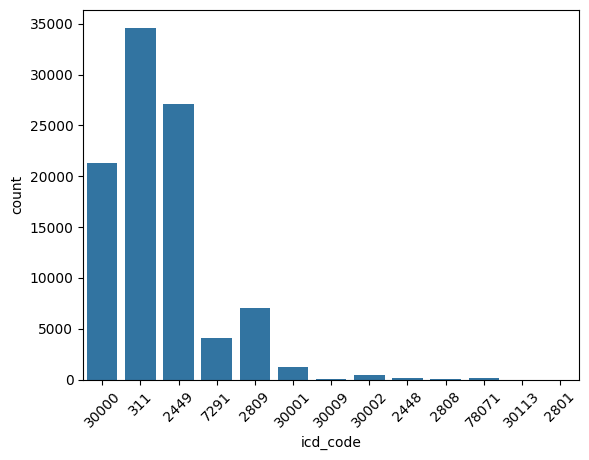

In [ ]:
#bar chart show how many imputs there are for each icd code
import matplotlib.pyplot as plt
import seaborn as sns
sns.countplot(diagnoses_filtered, x= 'icd_code')
plt.xticks(rotation=45)
plt.show()

In [ ]:
#group by each condition
diagnoses_filtered.loc[diagnoses_filtered['icd_code'].isin(['2448', '2449']),'condition'] = 'hypothyroidism'
diagnoses_filtered.loc[diagnoses_filtered['icd_code'].isin(['30000', '30001', '30002', '30009']),'condition'] = 'anxiety'
diagnoses_filtered.loc[diagnoses_filtered['icd_code'].isin(['30113']),'condition'] = 'cyclothymia'
diagnoses_filtered.loc[diagnoses_filtered['icd_code'].isin(['2801', '2808', '2809']),'condition'] = 'iron deficiency'
diagnoses_filtered.loc[diagnoses_filtered['icd_code'].isin(['78071']),'condition'] = 'chronic fatigue syndrome'
diagnoses_filtered.loc[diagnoses_filtered['icd_code'].isin(['7291']),'condition'] = 'fibromyalgia'
diagnoses_filtered.loc[diagnoses_filtered['icd_code'].isin(['311']),'condition'] = 'depression'
print(diagnoses_filtered['condition'].unique())
print(diagnoses_filtered.head())

['anxiety' 'depression' 'hypothyroidism' 'fibromyalgia' 'iron deficiency'
 'chronic fatigue syndrome' 'cyclothymia']
     subject_id   hadm_id  seq_num icd_code  icd_version   condition
126    10000826  20032235       14    30000            9     anxiety
145    10000883  25221576        2    30000            9     anxiety
147    10000883  29957930        2    30000            9     anxiety
159    10000935  21738619        9      311            9  depression
179    10000935  25849114       10      311            9  depression


<ipython-input-9-9ccac45162a8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diagnoses_filtered.loc[diagnoses_filtered['icd_code'].isin(['2448', '2449']),'condition'] = 'hypothyroidism'


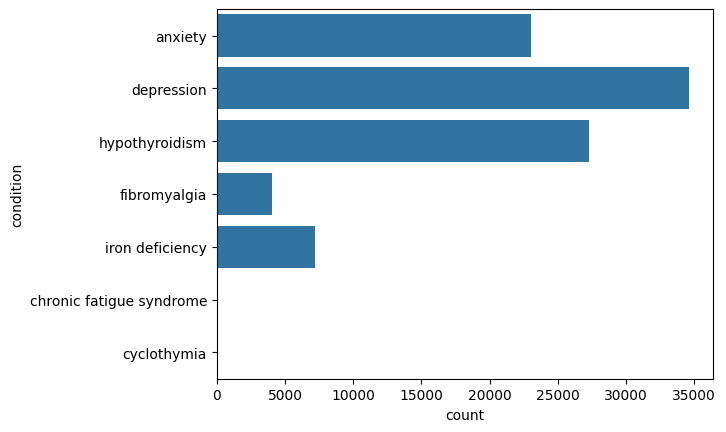

In [ ]:
#table of the amount of times each condition is documented
sns.countplot(diagnoses_filtered, y= 'condition')
plt.show()

In [ ]:
#since in the table above cfs and cyclothymia have very few  this is the exact count
cfs = diagnoses_filtered[diagnoses_filtered['condition']=='chronic fatigue syndrome']
cyclothymia = diagnoses_filtered[diagnoses_filtered['condition']=='cyclothymia']
print(len(cfs))
print(len(cyclothymia))
#might not be worth it to use the data for cyclothymia since it is so low compared to the others

115
6


In [ ]:
#check what lab items table looks like
print(lab_items.head())
print(len(lab_items))
print(lab_items['category'].unique())
print(lab_items['label'].nunique())
print(lab_items['label'].unique())
print(lab_items['fluid'].unique())

   itemid                                label  fluid   category
0   50801           Alveolar-arterial Gradient  Blood  Blood Gas
1   50802                          Base Excess  Blood  Blood Gas
2   50803  Calculated Bicarbonate, Whole Blood  Blood  Blood Gas
3   50804                 Calculated Total CO2  Blood  Blood Gas
4   50805                    Carboxyhemoglobin  Blood  Blood Gas
1622
['Blood Gas' 'Chemistry' 'Hematology']
1170
['Alveolar-arterial Gradient' 'Base Excess'
 'Calculated Bicarbonate, Whole Blood' ... 'Anti-la' 'HIV FINAL'
 'HIV Screen']
['Blood' 'Other Body Fluid' 'Ascites' 'Joint Fluid' 'Pleural' 'Stool'
 'Urine' 'Bone Marrow' 'Cerebrospinal Fluid' 'Fluid' 'I' 'Q']


In [ ]:
# Create a TextFileReader object by reading the CSV file in chunks
#10 chunks worked when reduced to 5 it crashed
labs_reader = pd.read_csv('labevents.csv.gz', compression='gzip', chunksize=11820000)

Just working on first chunk now. In end might save each one to seperate csv files and combine the filtered version so it dosen't crash.

In [ ]:
#name chunk that will be used in this data testing
chunk1 = next(labs_reader)
print(chunk1.head())

   labevent_id  subject_id  hadm_id  specimen_id  itemid order_provider_id  \
0            1    10000032      NaN     45421181   51237            P28Z0X   
1            2    10000032      NaN     45421181   51274            P28Z0X   
2            3    10000032      NaN     52958335   50853            P28Z0X   
3            4    10000032      NaN     52958335   50861            P28Z0X   
4            5    10000032      NaN     52958335   50862            P28Z0X   

             charttime            storetime value  valuenum valueuom  \
0  2180-03-23 11:51:00  2180-03-23 15:15:00   1.4       1.4      NaN   
1  2180-03-23 11:51:00  2180-03-23 15:15:00   ___      15.1      sec   
2  2180-03-23 11:51:00  2180-03-25 11:06:00   ___      15.0    ng/mL   
3  2180-03-23 11:51:00  2180-03-23 16:40:00   102     102.0     IU/L   
4  2180-03-23 11:51:00  2180-03-23 16:40:00   3.3       3.3     g/dL   

   ref_range_lower  ref_range_upper      flag priority  \
0              0.9              1.1  abn

In [ ]:
#merge chunk with lab item table
first_chunk_merg = pd.merge(chunk1, lab_items, on='itemid', how='left')
print(first_chunk_merg.head())

   labevent_id  subject_id  hadm_id  specimen_id  itemid order_provider_id  \
0            1    10000032      NaN     45421181   51237            P28Z0X   
1            2    10000032      NaN     45421181   51274            P28Z0X   
2            3    10000032      NaN     52958335   50853            P28Z0X   
3            4    10000032      NaN     52958335   50861            P28Z0X   
4            5    10000032      NaN     52958335   50862            P28Z0X   

             charttime            storetime value  valuenum valueuom  \
0  2180-03-23 11:51:00  2180-03-23 15:15:00   1.4       1.4      NaN   
1  2180-03-23 11:51:00  2180-03-23 15:15:00   ___      15.1      sec   
2  2180-03-23 11:51:00  2180-03-25 11:06:00   ___      15.0    ng/mL   
3  2180-03-23 11:51:00  2180-03-23 16:40:00   102     102.0     IU/L   
4  2180-03-23 11:51:00  2180-03-23 16:40:00   3.3       3.3     g/dL   

   ref_range_lower  ref_range_upper      flag priority  \
0              0.9              1.1  abn

In [ ]:
#filter first_chunk_merg for patients from diagnosed table
labs_chunk1_merg_filter = first_chunk_merg[first_chunk_merg['subject_id'].isin(subject_id_list)]

In [ ]:
#check if worked and is reduced
print(labs_chunk1_merg_filter.shape)
print(first_chunk_merg.shape)

(3876648, 19)
(11820000, 19)


In [ ]:
#check omr table and size
print(omr.shape)
print(omr.head())

(6439169, 5)
   subject_id   chartdate  seq_num      result_name result_value
0    10000032  2180-04-27        1   Blood Pressure       110/65
1    10000032  2180-04-27        1     Weight (Lbs)           94
2    10000032  2180-05-07        1      BMI (kg/m2)         18.0
3    10000032  2180-05-07        1  Height (Inches)           60
4    10000032  2180-05-07        1     Weight (Lbs)        92.15


In [ ]:
#filter by subject IDs that we are using
omr_filtered = omr[omr['subject_id'].isin(subject_id_list)]
print(omr.shape)
print(omr_filtered.shape)

(6439169, 5)
(1940194, 5)


In [ ]:
#find all omr result names (which is the names to each test that is run)
print(omr_filtered['result_name'].unique())

['Blood Pressure' 'Weight (Lbs)' 'BMI (kg/m2)' 'Height (Inches)'
 'Blood Pressure Lying' 'Blood Pressure Sitting'
 'Blood Pressure Standing (1 min)' 'eGFR'
 'Blood Pressure Standing (3 mins)' 'Blood Pressure Standing' 'BMI'
 'Weight' 'Height']


In [ ]:
#checking if 'height inches' and 'height' are using the same measure
omr_filtered[omr_filtered['result_name']=='Height'].head(10)

,subject_id,chartdate,seq_num,result_name,result_value
461757,10738205,2174-09-12,1,Height,62.50
1311196,12069725,2208-07-27,1,Height,66.50
2037316,13182131,2193-07-07,1,Height,63.60
2362744,13681703,2187-05-08,1,Height,62.0
2953983,14605976,2166-12-30,1,Height,59.0
2973746,14635690,2164-11-10,1,Height,64.50
4021154,16260607,2194-07-26,1,Height,73.0
5226279,18124591,2142-08-07,1,Height,70.50
5270585,18204587,2157-12-06,1,Height,67.0


In [ ]:
#checking if 'weight' and 'weight (Lbs)' are the same measure.
#ordered the data to get the lowest first- if it was Kg it would be lower
omr_filtered[omr_filtered['result_name']=='Weight'].sort_values(by='result_value').head(10)


,subject_id,chartdate,seq_num,result_name,result_value
4099786,16385283,2211-03-23,1,Weight,108.0
6371475,19895232,2170-10-12,1,Weight,111.60
5061375,17860497,2158-02-11,1,Weight,112.90
6342751,19854363,2196-12-03,1,Weight,115.00
5407608,18418634,2123-10-13,1,Weight,115.30
1749937,12743264,2130-03-17,1,Weight,116.0
5924261,19207802,2193-09-07,1,Weight,117.00
2756022,14295224,2168-06-15,1,Weight,118.00
3264253,15097184,2136-06-14,1,Weight,121.00
387707,10620077,2182-10-24,1,Weight,125.0


In [ ]:
#check if BMI is within range of BMI (kg/m2)
omr_filtered[omr_filtered['result_name']=='BMI'].sort_values(by='result_value').head(10)


,subject_id,chartdate,seq_num,result_name,result_value
1351364,12137322,2126-02-14,1,BMI,16.0
3260428,15092180,2189-09-27,1,BMI,18.0
3642347,15662564,2134-07-22,1,BMI,18.0
1749931,12743264,2130-02-04,1,BMI,18.0
1351366,12137322,2126-03-24,1,BMI,18.0
2249169,13505524,2131-01-18,1,BMI,19.0
2489041,13884635,2161-10-14,1,BMI,21.0
5807959,19017190,2189-08-24,1,BMI,21.0
5061372,17860497,2157-12-16,1,BMI,21.0
5718783,18889286,2158-11-15,1,BMI,21.0


In [ ]:
#consolidating like measures (that were previously checked)
omr_filtered.loc[omr_filtered['result_name']=='Height', 'result_name'] = 'Height (Inches)'
omr_filtered.loc[omr_filtered['result_name']=='Weight', 'result_name'] = 'Weight (Lbs)'
omr_filtered.loc[omr_filtered['result_name']=='BMI (kg/m2)', 'result_name'] = 'BMI'
print(omr_filtered['result_name'].unique())


['Blood Pressure' 'Weight (Lbs)' 'BMI' 'Height (Inches)'
 'Blood Pressure Lying' 'Blood Pressure Sitting'
 'Blood Pressure Standing (1 min)' 'eGFR'
 'Blood Pressure Standing (3 mins)' 'Blood Pressure Standing']


In [ ]:
#filter omr to only have the blood pressure measures to see how many there are of each
omr_blood_pressure = omr_filtered[omr_filtered['result_name'].isin(['Blood Pressure',
 'Blood Pressure Sitting', 'Blood Pressure Standing (1 min)',
 'Blood Pressure Lying', 'Blood Pressure Standing (3 mins)',
 'Blood Pressure Standing'])]

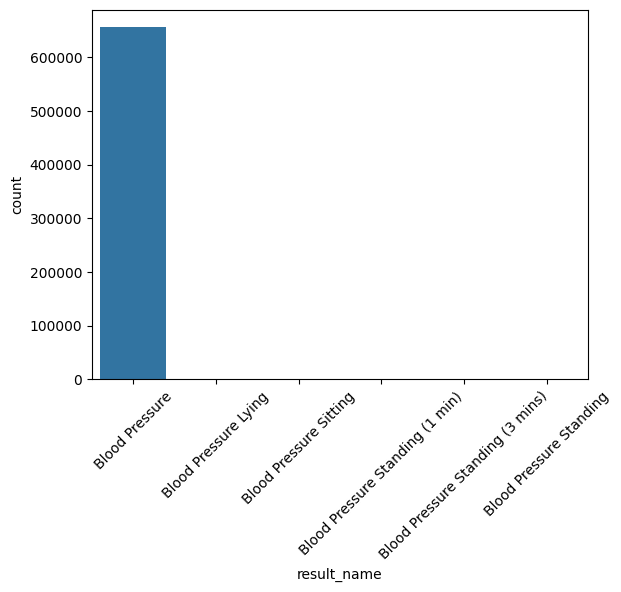

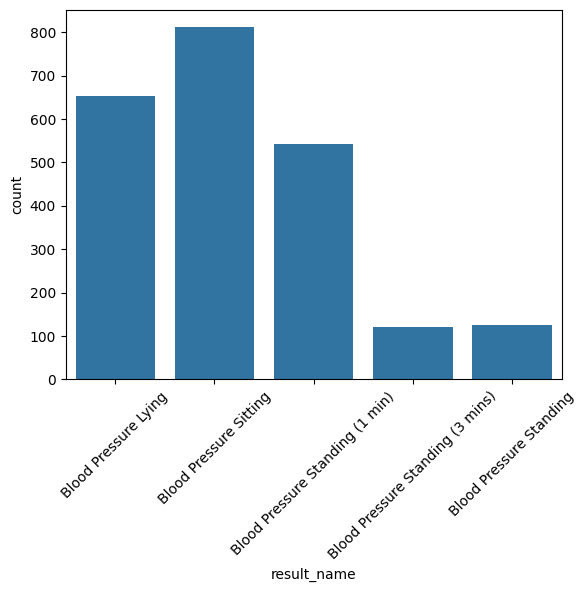

In [ ]:
#barchart showing the counts of each different blood pressure result to evaluate if it is a necessary distiction
import matplotlib.pyplot as plt
import seaborn as sns
sns.countplot(omr_blood_pressure, x='result_name')
plt.xticks(rotation=45)
plt.show()

#another barchart without the main one to see the other counts since the other graph showed close to zero for the other types of blood pressure
omr_blood_pressure_filtered = omr_blood_pressure[omr_blood_pressure['result_name']!='Blood Pressure']
sns.countplot(omr_blood_pressure_filtered, x='result_name')
plt.xticks(rotation=45)
plt.show()

The results show that the mass majority is just called blood pressure with no differentiation. There are over 600,000 blood pressure and only 2,000 of the others combined

In [ ]:
#since there is not as much other blood pressure results aside from the first one for our tests it would be easier to convert them all into one result name
#consolidate all blood pressure values
omr_filtered.loc[omr_filtered['result_name'].isin([ 'Blood Pressure Sitting', 'Blood Pressure Standing (1 min)',
 'Blood Pressure Lying', 'Blood Pressure Standing (3 mins)',
 'Blood Pressure Standing']), 'result_name'] = 'Blood Pressure'
print(omr_filtered['result_name'].unique())

['Blood Pressure' 'Weight (Lbs)' 'BMI' 'Height (Inches)' 'eGFR']


In [ ]:
#analysis of the omr table after modification
print(omr_filtered.head())
print(omr_filtered.shape)
print(omr_filtered['seq_num'].unique())
print(omr_filtered['subject_id'].nunique())

     subject_id   chartdate  seq_num     result_name result_value
231    10000826  2146-12-26        1  Blood Pressure        88/58
232    10000826  2146-12-26        1    Weight (Lbs)         98.9
233    10000826  2146-12-30        1  Blood Pressure       104/69
234    10000826  2147-01-15        1  Blood Pressure       102/60
235    10000826  2147-01-15        1    Weight (Lbs)       144.75
(1940194, 5)
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]
27291


     subject_id   hadm_id  seq_num icd_code  icd_version   condition
126    10000826  20032235       14    30000            9     anxiety
145    10000883  25221576        2    30000            9     anxiety
147    10000883  29957930        2    30000            9     anxiety
159    10000935  21738619        9      311            9  depression
179    10000935  25849114       10      311            9  depression
(96280, 6)
subject_id     0
hadm_id        0
seq_num        0
icd_code       0
icd_version    0
condition      0
dtype: int64
subject_id     39097
hadm_id        76700
seq_num           39
icd_code          13
icd_version        1
condition          7
dtype: int64


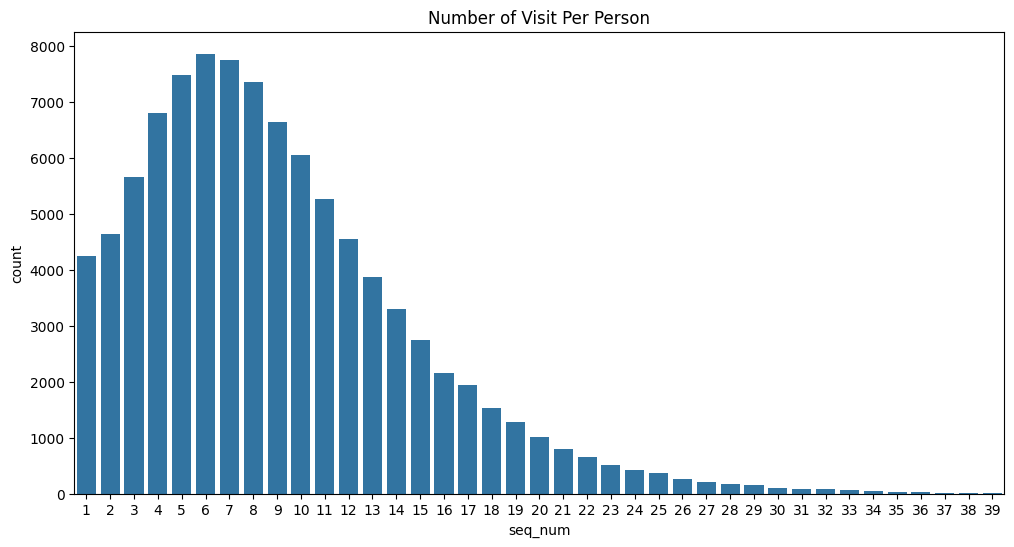

In [ ]:
#checking for null values
print(diagnoses_filtered.head())
print(diagnoses_filtered.shape)
print(diagnoses_filtered.isna().sum())
#see how many unique values for each compared to overall size of data frame
print(diagnoses_filtered.nunique())
#has 96280 rows, but only 39097 different people and most someone visited is 39. see how often most people visit er.
plt.figure(figsize=(12, 6))
sns.countplot(diagnoses_filtered, x='seq_num')
plt.title('Number of Visit Per Person')
plt.show()

Right tailed with 6 visits for most people with one of these diagnoses. will look at each condition seperately

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:718: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


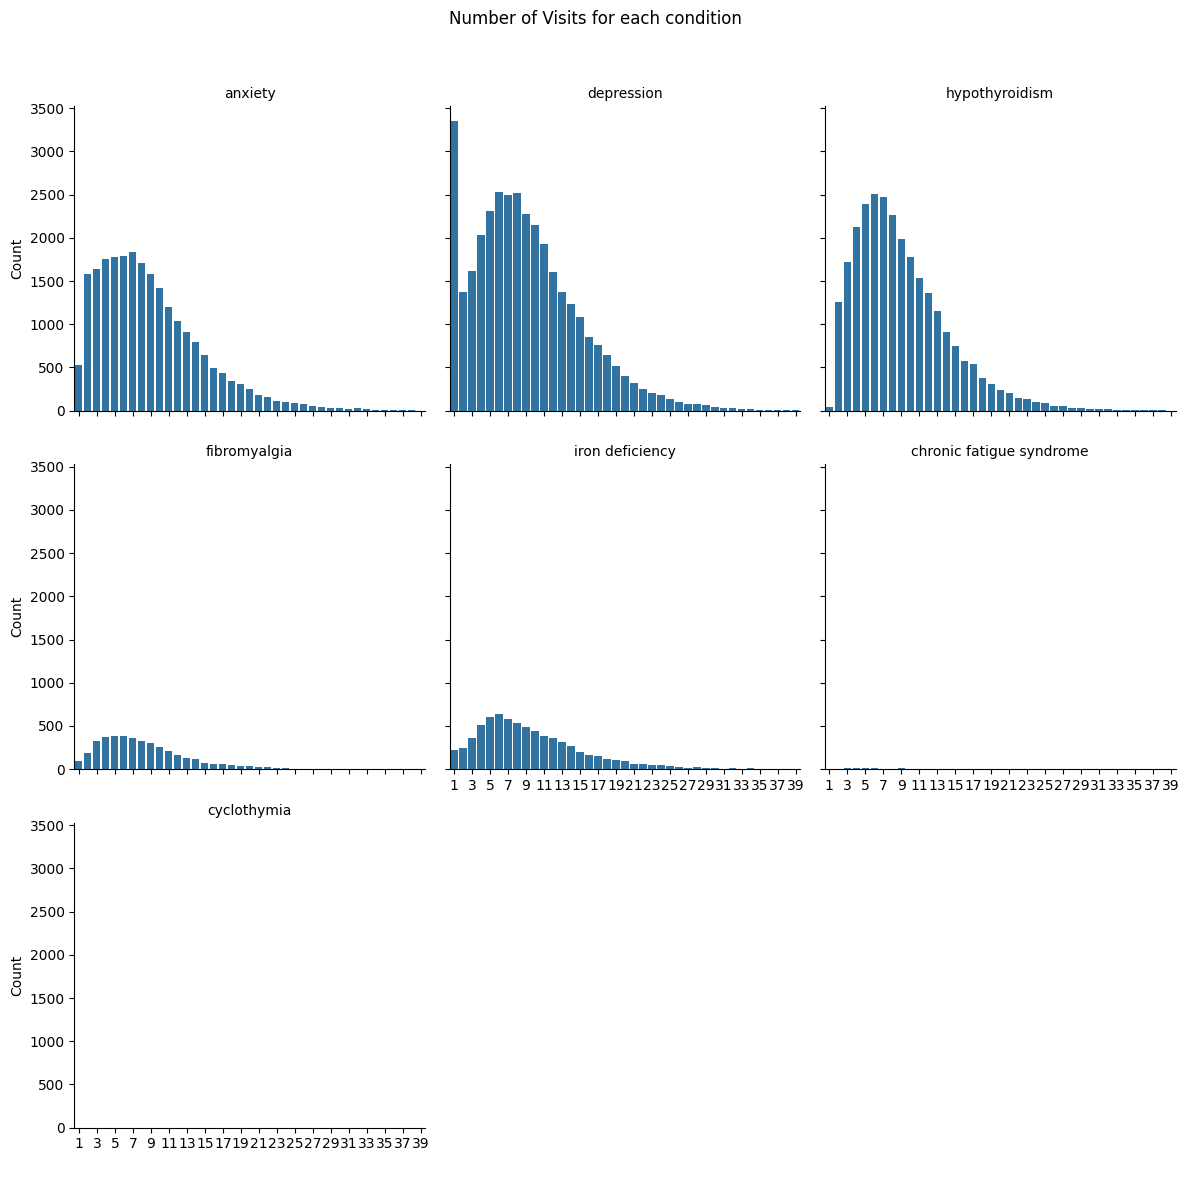

In [ ]:
#plotting for number of visits for each condition
g = sns.FacetGrid(diagnoses_filtered, col='condition', col_wrap=3, height=4)

# Plot countplots for each condition
g.map(sns.countplot, 'seq_num' )

# Set titles for each graph
g.set_titles('{col_name}')

# Set labels and adjust layout
g.set_axis_labels(' ', 'Count')
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Number of Visits for each condition')
plt.gca().set_xticks(plt.gca().get_xticks()[::2])  # Leave out every second x tick label

plt.show()

overall the distributions are pretty similar but the greatest execption is the first visit. the amount of people that are diagnosed with hypothrodism on the first visit is very small compared to others especially depression.

In [ ]:
#coloums in the diagnoses table
diagnoses_filtered.columns

Index(['subject_id', 'hadm_id', 'seq_num', 'icd_code', 'icd_version',
       'condition'],
      dtype='object')

In [ ]:
#will remove columns and create a reduced list with just subject id and condition
diagnoses_reduced = diagnoses_filtered[['subject_id','condition']]
diagnoses_reduced.shape

(96280, 2)

(3876648, 19)
labevent_id                0
subject_id                 0
hadm_id              1758880
specimen_id                0
itemid                     0
order_provider_id    2879561
charttime                  0
storetime              65036
value                 406174
valuenum              574356
valueuom              569596
ref_range_lower       703558
ref_range_upper       703558
flag                 2724749
priority              173821
comments             3186220
label                      0
fluid                      0
category                   0
dtype: int64


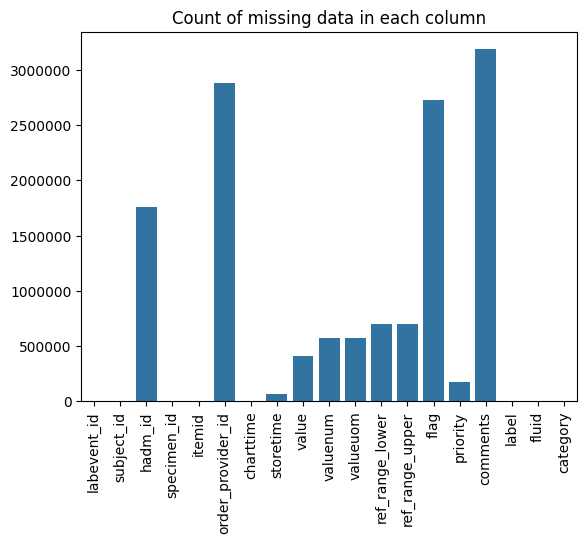

In [ ]:
#checking data and cleaning
print(labs_chunk1_merg_filter.shape)
print(labs_chunk1_merg_filter.isna().sum())
data_na = pd.DataFrame(labs_chunk1_merg_filter.isna().sum()).reset_index()
#plot missing data
sns.barplot(data=data_na, x='index',y=0)
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=90)
plt.title('Count of missing data in each column')
plt.ylabel("")
plt.xlabel("")
plt.show()
#remove hadm_id and order_provider_id and comments too many null values

In [ ]:
#remove hadm_id','order_provider_id','comments' too many null values not useful. will also drop timings for now.
#also remove ref range lower and upper for now. bec seems like if not in range it's flagged as abnormal go off that value for now.
labs_chunk1_merg_filter =labs_chunk1_merg_filter.drop(['hadm_id','order_provider_id',
                                                       'comments', 'charttime','storetime','ref_range_lower','ref_range_upper'],axis = 1)


In [ ]:
#analysis of the altered table from above
print(labs_chunk1_merg_filter.shape)
print(labs_chunk1_merg_filter.info())
print(labs_chunk1_merg_filter.nunique())


(3876648, 12)
<class 'pandas.core.frame.DataFrame'>
Index: 3876648 entries, 2643 to 11819999
Data columns (total 12 columns):
 #   Column       Dtype  
---  ------       -----  
 0   labevent_id  int64  
 1   subject_id   int64  
 2   specimen_id  int64  
 3   itemid       int64  
 4   value        object 
 5   valuenum     float64
 6   valueuom     object 
 7   flag         object 
 8   priority     object 
 9   label        object 
 10  fluid        object 
 11  category     object 
dtypes: float64(1), int64(4), object(7)
memory usage: 384.5+ MB
None
labevent_id    3876648
subject_id        3881
specimen_id     443931
itemid             825
value             9053
valuenum         10377
valueuom            56
flag                 1
priority             2
label              650
fluid                9
category             3
dtype: int64


In [ ]:
print(labs_chunk1_merg_filter['priority'].unique())
#change all 'priority' nan's to routine bec if not stat label prob routine
labs_chunk1_merg_filter['priority'] = labs_chunk1_merg_filter['priority'].fillna('ROUTINE')
print(labs_chunk1_merg_filter['flag'].unique())
#change all flag nan's to normal bec if not flagged as abnormal then its normal
labs_chunk1_merg_filter['flag'] = labs_chunk1_merg_filter['flag'].fillna('normal')
#check if null values were removed
print(labs_chunk1_merg_filter.isna().sum())

['STAT' nan 'ROUTINE']
[nan 'abnormal']
labevent_id         0
subject_id          0
specimen_id         0
itemid              0
value          406174
valuenum       574356
valueuom       569596
flag                0
priority            0
label               0
fluid               0
category            0
dtype: int64


In [ ]:
#finding all unique values
values = labs_chunk1_merg_filter['value'].unique()

In [ ]:
print((labs_chunk1_merg_filter['value'] == 'HOLD.  DISCARD GREATER THAN 24 HRS OLD.').sum())
#remove all rows of old labs not usable
labs_chunk1_merg_filter = labs_chunk1_merg_filter[labs_chunk1_merg_filter['value'] != 'HOLD.  DISCARD GREATER THAN 24 HRS OLD.']
#validate that were dropped
print((labs_chunk1_merg_filter['value'] == 'HOLD.  DISCARD GREATER THAN 24 HRS OLD.').sum())

9229
0


In [ ]:
values = labs_chunk1_merg_filter['value'].unique()

In [ ]:
#extract all that are not numeric and see how can handle them
print(len(values))
# Assuming 'values' is your list
non_numeric_values = [value for value in values if not (isinstance(value, float) or value.isdigit())]

print(len(non_numeric_values))

9053
5035


In [ ]:
#also remove fluid and category columns as well as lab event speciment and. will remove value columns as
# numeric values are in next column and not able to work with non numeric values now.
labs_chunk1_merg_filter =labs_chunk1_merg_filter.drop(['fluid','category',
                                                       'labevent_id', 'specimen_id','value'],axis = 1)
print(labs_chunk1_merg_filter.head())

      subject_id  itemid  valuenum valueuom      flag priority  \
2644    10000826   50955       NaN      NaN    normal     STAT   
2645    10000826   51237       1.3      NaN  abnormal     STAT   
2646    10000826   51274      15.2      sec  abnormal     STAT   
2647    10000826   51275      26.0      sec    normal     STAT   
2648    10000826   51146       1.7        %    normal     STAT   

                     label  
2644  Light Green Top Hold  
2645               INR(PT)  
2646                    PT  
2647                   PTT  
2648             Basophils  


In [ ]:
filtered_df = labs_chunk1_merg_filter

In [ ]:
#Really should go through all and see which ones are for sure not related now don't have much time
#will just go with if flagged and not with actual numbers
#actual label not important for model can recombine it afterwards but save a copy with label
filtered_df = labs_chunk1_merg_filter
labs_chunk1_merg_filter =labs_chunk1_merg_filter.drop(['valuenum', 'valueuom','label' ],axis = 1)
print(labs_chunk1_merg_filter.head())

      subject_id  itemid      flag priority
2644    10000826   50955    normal     STAT
2645    10000826   51237  abnormal     STAT
2646    10000826   51274  abnormal     STAT
2647    10000826   51275    normal     STAT
2648    10000826   51146    normal     STAT


In [ ]:
#combine with diagnoses table and omr on subject id
merged_labdg = pd.merge(labs_chunk1_merg_filter, diagnoses_reduced, on='subject_id', how='left')
print(merged_labdg.head())

   subject_id  itemid      flag priority condition
0    10000826   50955    normal     STAT   anxiety
1    10000826   51237  abnormal     STAT   anxiety
2    10000826   51274  abnormal     STAT   anxiety
3    10000826   51275    normal     STAT   anxiety
4    10000826   51146    normal     STAT   anxiety


In [ ]:
#only keep ones that were flagged as abnormal
merged_labdg = merged_labdg[merged_labdg['flag'] == 'abnormal']
#create copy bec will remove values from first list
merged_labdg_full = merged_labdg

In [ ]:
#run loop to retrun the the top 20 tests with abnormal result that have hypothrodism
# Initialize an empty list to store the mode for 'hypothyroidism' for each round
mode_list = []
hypo_mode_list = []

# Loop for 20 rounds
for i in range(1, 21):

    # Group by 'condition' and find the mode of 'itemid' for each condition
    stats = merged_labdg.groupby('condition')['itemid'].agg(mode=lambda x: x.mode().iloc[0])

    # Append the mode for 'hypothyroidism' to the list
    stats.reset_index(inplace=True)
    hypothyroidism_mode = stats.iloc[5,1]
    mode_list.append(stats)
    hypo_mode_list.append(hypothyroidism_mode)

    # Remove rows where 'itemid' is equal to the mode for 'hypothyroidism'
    merged_labdg = merged_labdg[merged_labdg['itemid'] != hypothyroidism_mode]


# Print the DataFrame
print(hypo_mode_list)

[51279, 51221, 51222, 50931, 51006, 51277, 50912, 51248, 51237, 51274, 51301, 51250, 50893, 51265, 51249, 50902, 50970, 51256, 50882, 52172]


In [ ]:
with_labels = filtered_df[filtered_df['itemid'].isin(hypo_mode_list)]
#combine with diagnoses table on subject id
with_labels = pd.merge(with_labels, diagnoses_reduced, on='subject_id', how='left')
print(with_labels['label'].unique())

['INR(PT)' 'PT' 'Hematocrit' 'Hemoglobin' 'MCH' 'MCHC' 'MCV' 'Neutrophils'
 'Platelet Count' 'RDW' 'Red Blood Cells' 'White Blood Cells'
 'Bicarbonate' 'Chloride' 'Creatinine' 'Glucose' 'Urea Nitrogen'
 'Calcium, Total' 'Phosphate' 'RDW-SD']


In [ ]:
#filter list for these 20 lab item ids
labs_chunk1_merg_filter = merged_labdg_full[merged_labdg_full['itemid'].isin(hypo_mode_list)]
#print(filtered_merged_labdg.shape)

In [ ]:
#filter to only the ones which are abnormal and try to see which tests with abnormal reslults can predict hypothrodism
labs_chunk1_merg_filter = labs_chunk1_merg_filter[labs_chunk1_merg_filter['flag'] == 'abnormal']
print(labs_chunk1_merg_filter.shape)
#drop flag column since only have abnormal now
labs_chunk1_merg_filter =labs_chunk1_merg_filter.drop(['flag'],axis = 1)
#turn priority column stat into 1
# Define the mapping dictionary
priority_mapping = {'STAT': 1, 'ROUTINE': 0}

# Replace values using the mapping dictionary
labs_chunk1_merg_filter['priority'] = labs_chunk1_merg_filter['priority'].replace(priority_mapping)

# Print unique values to verify the transformation
print(labs_chunk1_merg_filter['priority'].unique())

#change name to priority_stat
labs_chunk1_merg_filter = labs_chunk1_merg_filter.rename(columns={'priority': 'priority_stat'})

# Print the updated DataFrame to verify the change
print(labs_chunk1_merg_filter.head())

(4574979, 5)
[1 0]
    subject_id  itemid  priority_stat condition
1     10000826   51237              1   anxiety
2     10000826   51274              1   anxiety
9     10000826   51248              1   anxiety
11    10000826   51250              1   anxiety
13    10000826   51256              1   anxiety


In [ ]:
print(labs_chunk1_merg_filter.head())

    subject_id  itemid  priority_stat condition
1     10000826   51237              1   anxiety
2     10000826   51274              1   anxiety
9     10000826   51248              1   anxiety
11    10000826   51250              1   anxiety
13    10000826   51256              1   anxiety


In [ ]:
#turned omr into a pivot table
pivot_omr = omr_filtered.pivot_table(index = ['subject_id','chartdate'], columns='result_name', values='result_value', aggfunc='first').reset_index()

In [ ]:
pivot_omr[['systolic_pressure', 'diastolic_pressure']] = pivot_omr['Blood Pressure'].str.split('/', expand=True)
pivot_omr.drop(columns=['chartdate','Blood Pressure'], inplace=True)

In [ ]:
#remove duplicates of original diagnoses column
diagnoses_reduced.drop_duplicates(inplace=True)
print(len(diagnoses_reduced))

53411


<ipython-input-54-b8dc8d70162b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diagnoses_reduced.drop_duplicates(inplace=True)


In [ ]:
#group by each subject and date and remove data and height weight as have bmi
omr_red = pivot_omr.groupby(['subject_id'])
omr_red = pivot_omr[['subject_id','BMI', 'systolic_pressure', 'diastolic_pressure','eGFR']]
print(omr_red)

result_name  subject_id   BMI systolic_pressure diastolic_pressure eGFR
0              10000826   NaN                88                 58  NaN
1              10000826   NaN               104                 69  NaN
2              10000826   NaN               102                 60  NaN
3              10000826   NaN                90                 60  NaN
4              10000826   NaN               101                 64  NaN
...                 ...   ...               ...                ...  ...
683924         19999442  26.3               122                 82  NaN
683925         19999442  27.6               NaN                NaN  NaN
683926         19999625   NaN               NaN                NaN  NaN
683927         19999625   NaN               100                 60  NaN
683928         19999625   NaN                98                 60  NaN

[683929 rows x 5 columns]


In [ ]:
print(omr_red.isna().sum())
#will needto figure out how each person only have one line but for now fill na to 0 to run model
omr_red.fillna(0, inplace=True)
print(omr_red.isna().sum())

result_name
subject_id                 0
BMI                   190603
systolic_pressure      55400
diastolic_pressure     55400
eGFR                  683848
dtype: int64
result_name
subject_id            0
BMI                   0
systolic_pressure     0
diastolic_pressure    0
eGFR                  0
dtype: int64


<ipython-input-75-8ed953c2ec69>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  omr_red.fillna(0, inplace=True)


In [ ]:
#analysis of the omr_red table
print(omr_red.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 683929 entries, 0 to 683928
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   subject_id          683929 non-null  int64 
 1   BMI                 683929 non-null  object
 2   systolic_pressure   683929 non-null  object
 3   diastolic_pressure  683929 non-null  object
 4   eGFR                683929 non-null  object
dtypes: int64(1), object(4)
memory usage: 26.1+ MB
None


In [ ]:
#cleaning data so that it is all nuemeric
omr_red['BMI'] = omr_red['BMI'].str.replace(r'\D', '')
omr_red.fillna(0, inplace=True)
omr_red['BMI'] = pd.to_numeric(omr_red['BMI'],errors='coerce')

<ipython-input-89-29c9b7a24ebf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  omr_red['BMI'] = omr_red['BMI'].str.replace(r'\D', '')
<ipython-input-89-29c9b7a24ebf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  omr_red.fillna(0, inplace=True)
<ipython-input-89-29c9b7a24ebf>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

In [ ]:
#convet all other columns to numeric
omr_red['systolic_pressure'] = omr_red['systolic_pressure'].str.replace(r'\D', '')
omr_red.fillna(0, inplace=True)
omr_red['systolic_pressure'] = pd.to_numeric(omr_red['systolic_pressure'],errors='coerce')
#diastolic pressure
omr_red['diastolic_pressure'] = omr_red['diastolic_pressure'].str.replace(r'\D', '')
omr_red.fillna(0, inplace=True)
omr_red['diastolic_pressure'] = pd.to_numeric(omr_red['diastolic_pressure'],errors='coerce')
#egfr
omr_red['eGFR'] = omr_red['eGFR'].str.replace(r'\D', '')
omr_red.fillna(0, inplace=True)
omr_red['eGFR'] = pd.to_numeric(omr_red['eGFR'],errors='coerce')

<ipython-input-90-ac07d4fb4501>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  omr_red['systolic_pressure'] = omr_red['systolic_pressure'].str.replace(r'\D', '')
<ipython-input-90-ac07d4fb4501>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  omr_red.fillna(0, inplace=True)
<ipython-input-90-ac07d4fb4501>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

In [ ]:
#merge omr with diagnoses
merged_omr = pd.merge(omr_red, diagnoses_reduced, on='subject_id', how='left')
#change condition to boolean
merged_omr['condition'] = merged_omr['condition'].apply(lambda x: 1 if x == 'hypothyroidism' else 0)
print(merged_omr.head())

   subject_id  BMI  systolic_pressure  diastolic_pressure  eGFR  condition
0    10000826  0.0                 88                  58   0.0          0
1    10000826  0.0                104                  69   0.0          0
2    10000826  0.0                102                  60   0.0          0
3    10000826  0.0                 90                  60   0.0          0
4    10000826  0.0                101                  64   0.0          0


In [ ]:
#checking to make sure all the null values are filled with zeros for the model
merged_omr.fillna(0, inplace=True)
print(merged_omr.isna().sum())

subject_id            0
BMI                   0
systolic_pressure     0
diastolic_pressure    0
eGFR                  9
condition             0
dtype: int64
subject_id            0
BMI                   0
systolic_pressure     0
diastolic_pressure    0
eGFR                  0
condition             0
dtype: int64


In [ ]:
#change condition to boolean
labs_chunk1_merg_filter['condition'] = labs_chunk1_merg_filter['condition'].apply(lambda x: 1 if x == 'hypothyroidism' else 0)
#merged_labdg = pd.merge(labs_chunk1_merg_filter, diagnoses_reduced, on='subject_id', how='left')
merged_labdg = labs_chunk1_merg_filter
print(merged_labdg.head())

    subject_id  itemid  priority_stat  condition
1     10000826   51237              1          0
2     10000826   51274              1          0
9     10000826   51248              1          0
11    10000826   51250              1          0
13    10000826   51256              1          0


In [ ]:
#divide merged_labdg and merged_omr into testing and training groups
#but remember to keep each subject id in one of the groups
from sklearn.model_selection import train_test_split
# Split id's into training and testing sets for when split data
X_trainid, X_testid = train_test_split(subject_id_list, test_size=0.25, random_state=42)
# Print the shapes of the training and testing sets
print(X_trainid.shape)
print(X_testid.shape)

(72210,)
(24070,)


In [ ]:
#split merged_labdg according to id to ensure that each person stays in one group
X_train_labs = merged_labdg[merged_labdg['subject_id'].isin(X_trainid)]
X_test_labs = merged_labdg[~merged_labdg['subject_id'].isin(X_trainid)]
print(X_train_labs.shape)
print(X_test_labs.shape)

(4484971, 4)
(90008, 4)


In [ ]:
#split merged_omr according to id to ensure that each person stays in one group
X_train_omr = merged_omr[merged_omr['subject_id'].isin(X_trainid)]
X_test_omr = merged_omr[~merged_omr['subject_id'].isin(X_trainid)]
print(X_train_omr.shape)
print(X_test_omr.shape)

(992610, 6)
(77957, 6)


In [ ]:
#divide each into x and y. Y being condition
y_train_omr = X_train_omr['condition']
y_test_omr = X_test_omr['condition']
y_train_labs = X_train_labs['condition']
y_test_labs = X_test_labs['condition']

In [ ]:
#remove target and subject id so model dosen't use that to train
X_train_omr = X_train_omr.drop(['subject_id','condition'], axis=1)
X_test_omr = X_test_omr.drop(['subject_id','condition'], axis=1)
X_train_labs = X_train_labs.drop(['subject_id','condition'], axis=1)
X_test_labs = X_test_labs.drop(['subject_id','condition'], axis=1)

In [ ]:
def evaluate_models(X_train, X_test, y_train, y_test):
    #import models
    #logistic regression
    from sklearn.linear_model import LogisticRegression
    #gradient boosting
    from sklearn.ensemble import GradientBoostingRegressor
    # decision tree
    from sklearn.tree import DecisionTreeRegressor
    from sklearn.metrics import average_precision_score# try different models

    #list of models
    models=[LogisticRegression(),GradientBoostingRegressor(),DecisionTreeRegressor()]
    #empty list to store avg precision
    avg_precisions = []

    #run models
    for model in models:

      #fit the model
      model.fit(X_train,y_train_labs)
      y_pred = model.predict(X_test)
      # Calculate the average precision of the model
      avg_precision = average_precision_score(y_test, y_pred)

      # Append the average precision to the list
      avg_precisions.append(avg_precision)

    # Create a dataframe of the average precision of each model
    df_avg_precisions = pd.DataFrame({'Model': models, 'Average Precision': avg_precisions})

    # Print the dataframe
    print(df_avg_precisions)


In [ ]:
#run model on labs
evaluate_models(X_train_labs, X_test_labs, y_train_labs, y_test_labs)

                                               Model  Average Precision
0                               LogisticRegression()           0.361179
1  ([DecisionTreeRegressor(criterion='friedman_ms...           0.385699
2                            DecisionTreeRegressor()           0.384679


In [ ]:
#run model on omr
#since the last model took a very long time to run we were unable to finish running this in time for the project
evaluate_models(X_train_omr, X_test_omr, y_train_omr, y_test_omr)

ValueError: Found input variables with inconsistent numbers of samples: [992610, 4484971]